In [1]:
import pandas as pd
from matplotlib import pyplot as plt
#!pip install pivottablejs
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
lpop = pd.read_stata('ARG_2021_LAPOP_AmericasBarometer_v1.2_w.dta',convert_categoricals=False)
gpt = pd.read_csv('respuestas_gpt35_turbo')
cohere = pd.read_csv('respuestas_cohere.csv')
bard = pd.read_csv('respuestas_bard.csv')

In [3]:
# Crea un StataReader para leer los metadatos
reader = pd.io.stata.StataReader('ARG_2021_LAPOP_AmericasBarometer_v1.2_w.dta')

In [4]:
reader.value_labels()['q1tb_esp']

{1: 'Hombre/masculino', 2: 'Mujer/femenino', 3: 'Otro'}

In [5]:
import pickle
with open(r"respuestas.pickle", "rb") as input_file:
    respuestas = pickle.load(input_file)
with open(r"preguntas_seleccionadas.pickle", "rb") as input_file:
    preguntas_seleccionadas = pickle.load(input_file)

In [6]:
import math
def calculate_distance(responde,llm):    
    result = 0
    num_pregs = 0
    for pregunta in list(preguntas_seleccionadas.keys()):
        if((pregunta.lower() in responde.keys()) and (not math.isnan(responde[pregunta.lower()])) and (pregunta in list(llm['Pregunta'])) 
           and(llm[llm['Pregunta']== pregunta]['Respuesta'].values[0] < 10) ):
            
            result = result + (abs(responde[pregunta.lower()]-llm[llm['Pregunta']== pregunta]['Respuesta'].values[0]))
            num_pregs = num_pregs + 1
    if(num_pregs == 0):
        result = -1
        norm_result = -1
    else:
        norm_result = result/num_pregs
    
    return(result, num_pregs, norm_result)
calculate_distance(lpop.loc[0],bard)

(31.0, 18, 1.7222222222222223)

In [7]:
lpop = lpop.drop('a4', axis=1)

In [8]:
lpop['bard_results'] = lpop.apply(lambda x: calculate_distance(x, bard), axis=1)
lpop[['bard_distance', 'bard_num_preg','bard_distance_norm']] = pd.DataFrame(lpop['bard_results'].tolist(), index=lpop.index)

In [16]:
lpop[lpop['bard_distance']==0].shape

(1, 251)

<AxesSubplot:ylabel='Frequency'>

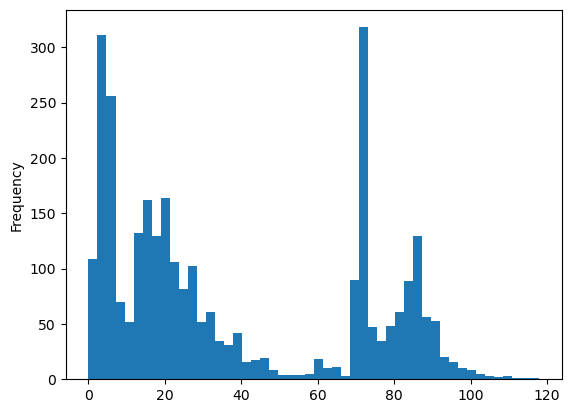

In [17]:
lpop['bard_distance'].plot(kind='hist', bins=50)

<AxesSubplot:title={'center':'Cantidad de preguntas Bard'}, ylabel='Frequency'>

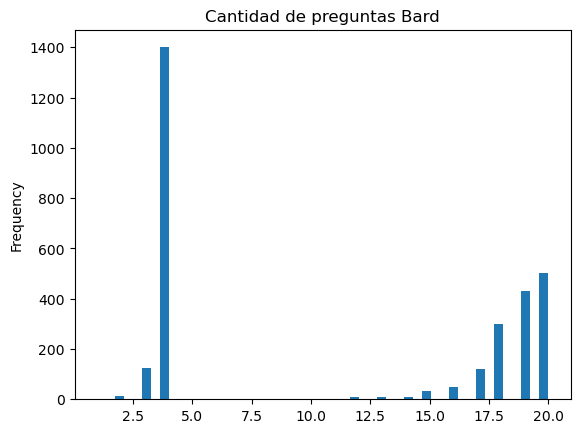

In [31]:
lpop['bard_num_preg'].plot(kind='hist', bins=50, title='Cantidad de preguntas Bard')

<AxesSubplot:title={'center':'Distancia normalizada Bard'}, ylabel='Frequency'>

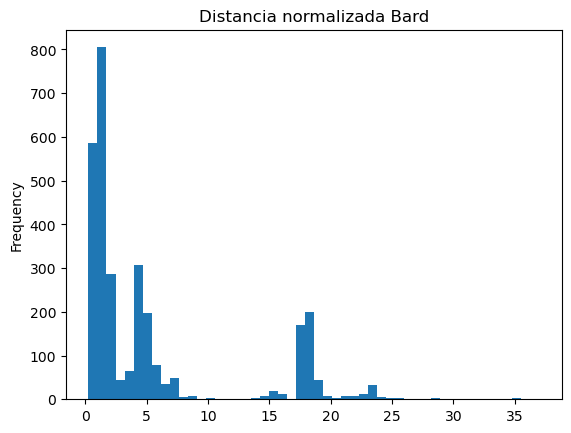

In [29]:
lpop[lpop['bard_num_preg']>1]['bard_distance_norm'].plot(kind='hist', bins=50,title='Distancia normalizada Bard')

In [ ]:
lpop_cohere['bard_distance_norm_wt'] =  lpop_cohere['bard_distance_norm'] * lpop_cohere['wt']

In [60]:
lpop = lpop.sort_values(by='bard_distance_norm', ascending=True)

# 2. Calcular el número de filas que representa el 10%
num_rows_10_percent = int(len(lpop) * 0.1)

# 3. Seleccionar las primeras filas correspondientes al 10%
lpop_cohere = lpop[(lpop['bard_num_preg']>5)].head(num_rows_10_percent)

In [11]:

lpop_cohere.shape[0]/lpop.shape[0]

0.09996678844237794

In [10]:
preguntas_gpt = []
for idx, responde in lpop_cohere.iterrows():
    for pregunta in list(preguntas_seleccionadas.keys()):
            if((pregunta.lower() in responde.keys()) and (not math.isnan(responde[pregunta.lower()])) and (pregunta in list(bard['Pregunta'])) 
               and(bard[bard['Pregunta']== pregunta]['Respuesta'].values[0] < 10) ):
                preguntas_gpt.append(pregunta.lower())

In [11]:
df_preg = pd.DataFrame(data={'preguntas':preguntas_gpt})
value_counts = df_preg['preguntas'].value_counts()
for pregunta, count in value_counts.items():
    print('-',pregunta,preguntas_seleccionadas[pregunta.upper()],': ',respuestas[pregunta.upper()][bard[bard['Pregunta']== pregunta.upper()]['Respuesta'].values[0]], count)
    print(" ")

- ing4 Puede que la democracia tenga problemas, pero es mejor que cualquier otra forma de gobierno. ¿Hasta qué punto está de acuerdo o en desacuerdo con esta frase? Por favor dígame su opinión usando una escala que va de 1, que significa “muy endesacuerdo” a 7, que significa “muy de acuerdo”. Puede usar cualquier número entre 1 y 7. :  6 301
 
- ctaware ¿Qué tanto conoce el trabajo que hace la Corte Suprema de Justicia de Argentina? :  Algo 300
 
- b2 ¿Hasta qué punto tiene usted respeto por las instituciones políticas de Argentina? Le pediré que responda las siguientes preguntas utilizando un número de una escala que va de 1 a 7, en la que 1 significa NADA y 7 significa MUCHO. Si su opinión está entre nada y mucho, elegiría un puntaje intermedio :  4 300
 
- b3 ¿Hasta qué punto cree usted que los derechos básicos del ciudadano están bien protegidos por el sistema político argentino? Le pediré que responda las siguientes preguntas utilizando un número de una escala que va de 1 a 7, en 

## Edad

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


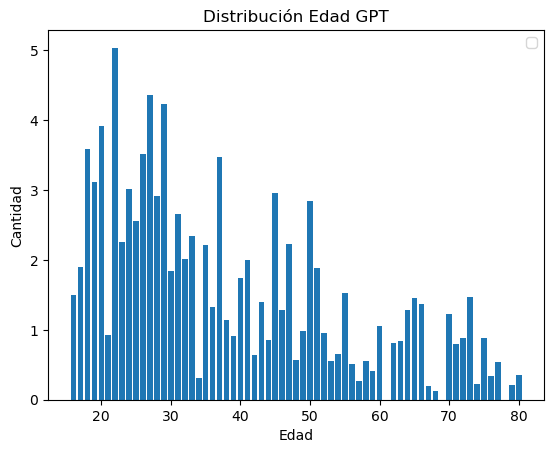

In [77]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_cohere.groupby('q2')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.title("Distribución Edad GPT")
plt.ylabel("Cantidad")
plt.xlabel("Edad")

plt.legend()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


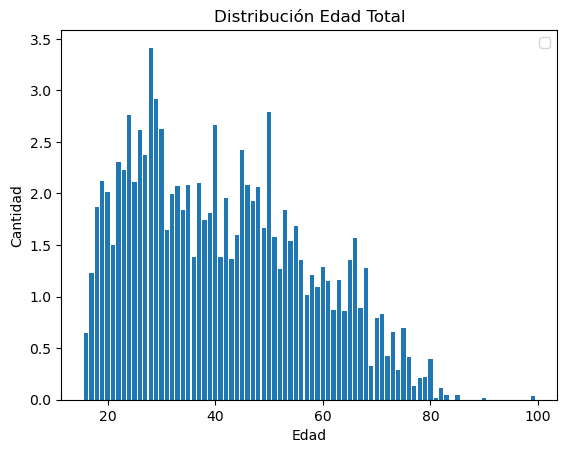

In [78]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop.groupby('q2')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.title("Distribución Edad Total")
plt.ylabel("Cantidad")
plt.xlabel("Edad")

plt.legend()
plt.show()



In [31]:
lpop_cohere_5p = lpop[(lpop['bard_num_preg']>5)]

In [79]:
from scipy.stats import ttest_ind

# Realizar la prueba 
estadistico, p_valor = ttest_ind((lpop_cohere['q2'].values), (lpop['q2'].values))

print("Estadístico de prueba t:", estadistico)
print("Valor p:", p_valor)

Estadístico de prueba t: -3.3333616963204777
Valor p: 0.000867468936816182


In [80]:
lpop_cohere['q2'].std()

15.503037961848369

In [81]:
lpop_cohere_5p['q2'].std()

15.198960005341432

In [82]:
lpop_cohere['q2'].median()

37.0

In [83]:
lpop_cohere_5p['q2'].median()

41.0

In [24]:
lpop_cohere['q2'].mean()

39.63787375415282

In [25]:
lpop['q2'].mean()

42.62504151444703

In [30]:
users_per_grade.median()

41.71773147583008

## Género

In [18]:
lpop_cohere['q1tb_label'] = lpop_cohere['q1tb'].apply(lambda x: reader.value_labels()['q1tb_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\1291482559.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['q1tb_label'] = lpop_cohere['q1tb'].apply(lambda x: reader.value_labels()['q1tb_esp'][x])


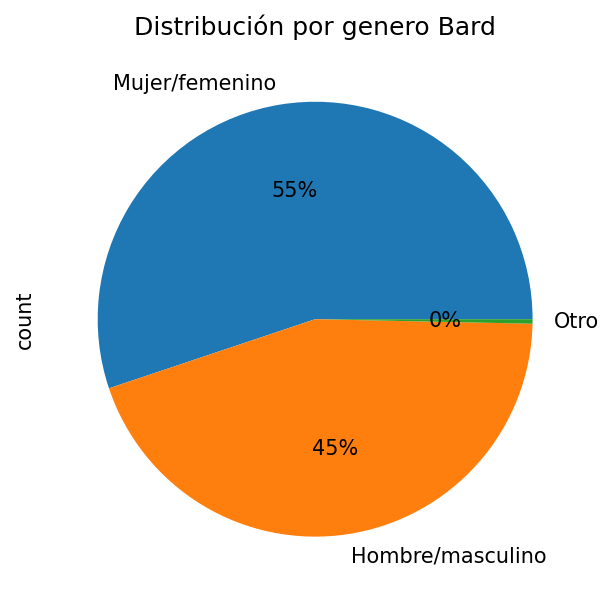

In [19]:
plt.figure(figsize=(6.4, 4.8), dpi=150)
lpop_cohere['q1tb_label'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)
plt.title('Distribución por genero Bard')
plt.savefig('genero Bard.png')
plt.show()

In [20]:
lpop['q1tb_label'] = lpop['q1tb'].apply(lambda x: reader.value_labels()['q1tb_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\1756115608.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['q1tb_label'] = lpop['q1tb'].apply(lambda x: reader.value_labels()['q1tb_esp'][x])


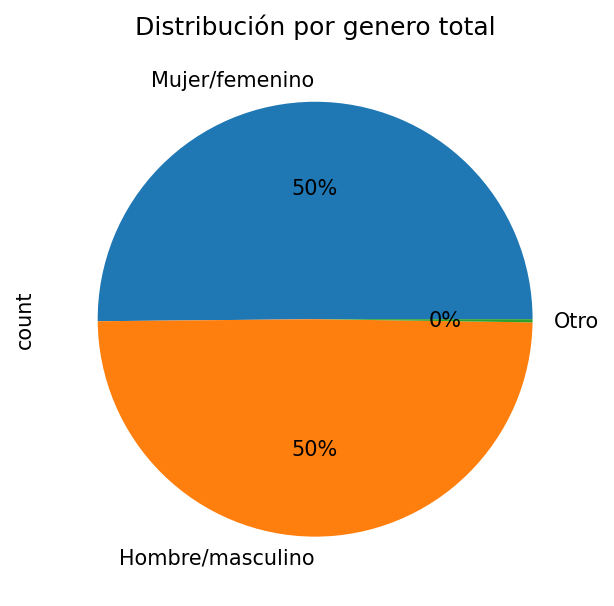

In [21]:
plt.figure(figsize=(6.4, 4.8), dpi=150)
lpop['q1tb_label'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)
plt.title('Distribución por genero total')
plt.savefig('genero otal.png')
plt.show()

In [23]:
from statsmodels.stats.proportion import proportions_ztest

# tamaños de las muestras
n_total = lpop.shape[0]# pon aquí el tamaño de la muestra total
n_submuestra = lpop_cohere.shape[0]# pon aquí el tamaño de la submuestra

# número de éxitos (en este caso, mujeres) en cada muestra
count_total = n_total * 0.50  # 50% de la muestra total son mujeres
count_submuestra = n_submuestra * 0.55  # 55% de la submuestra son mujeres

# realizamos el test de proporciones
z_stat, p_value = proportions_ztest([count_submuestra, count_total], [n_submuestra, n_total])

print('Z-statistic:', z_stat)
print('p-value:', p_value)

Z-statistic: 1.6542890590057466
p-value: 0.0980687949345106


## Provincia

In [24]:
import math
lpop_cohere['prov1t_label'] = lpop_cohere['prov1t'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['prov1t_eng'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\2688560247.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['prov1t_label'] = lpop_cohere['prov1t'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['prov1t_eng'][x])


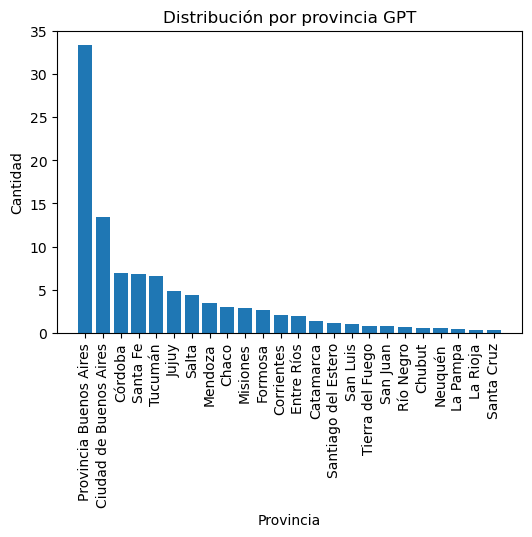

In [25]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_cohere.groupby('prov1t_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Provincia")
plt.title('Distribución por provincia GPT')
plt.xticks(rotation=90)
plt.show()



In [26]:
import math
lpop['prov1t_label'] = lpop['prov1t'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['prov1t_eng'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\699261593.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['prov1t_label'] = lpop['prov1t'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['prov1t_eng'][x])


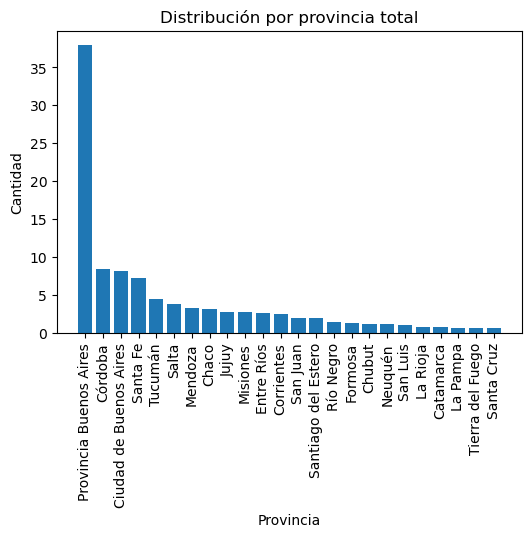

In [27]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('prov1t_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Provincia")
plt.title('Distribución por provincia total')
plt.xticks(rotation=90)
plt.show()



In [28]:
from scipy.stats import chi2_contingency


# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([list(users_per_grade_gpt.values), list(users_per_grade_total.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 31.088617613127646
Valor p: 0.12063151076487268


## Urbanización

In [29]:

lpop_cohere['ur1new_label'] = lpop_cohere['ur1new'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['ur1new_esp'][x])
lpop['ur1new_label'] = lpop['ur1new'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['ur1new_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\3492639426.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['ur1new_label'] = lpop_cohere['ur1new'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['ur1new_esp'][x])
C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\3492639426.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['ur1new_label'] = lpop['ur1new'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['ur1new_esp'][x])


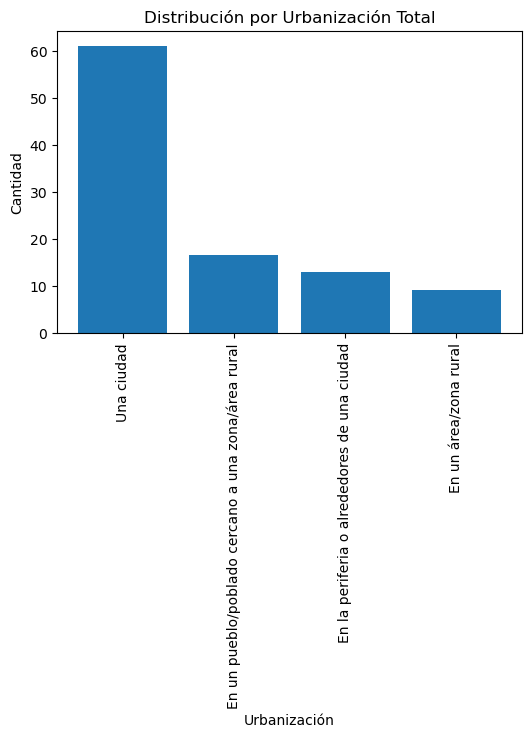

In [30]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('ur1new_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Urbanización")
plt.title('Distribución por Urbanización Total')
plt.xticks(rotation=90)
plt.show()


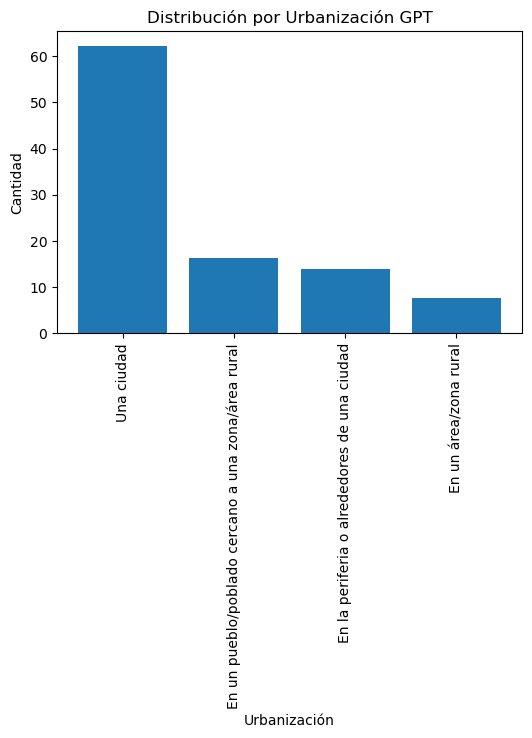

In [31]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_cohere.groupby('ur1new_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Urbanización")
plt.title('Distribución por Urbanización GPT')
plt.xticks(rotation=90)
plt.show()


In [32]:
from scipy.stats import chi2_contingency


# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([list(users_per_grade_gpt.values), list(users_per_grade_total.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 0.9052961723146447
Valor p: 0.8241495362235959


## Nivel educativo

In [33]:

lpop_cohere['edr_label'] = lpop_cohere['edr'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['edr_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\460240200.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['edr_label'] = lpop_cohere['edr'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['edr_esp'][x])


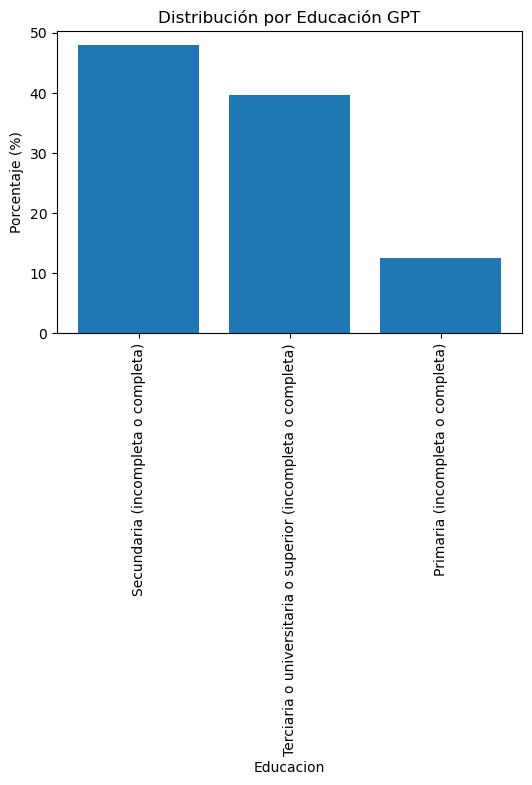

In [34]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_cohere.groupby('edr_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Educacion")
plt.title('Distribución por Educación GPT')
plt.xticks(rotation=90)
plt.show()

In [35]:
users_per_grade_pct_sorted

edr_label
Secundaria (incompleta o completa)                              47.874767
Terciaria o universitaria o superior (incompleta o completa)    39.698425
Primaria (incompleta o completa)                                12.426814
Name: wt, dtype: float32

In [38]:
users_per_grade_pct_sorted_total

edr_label
Secundaria (incompleta o completa)                              43.618168
Terciaria o universitaria o superior (incompleta o completa)    33.687271
Primaria (incompleta o completa)                                21.239805
Ninguna                                                          1.454757
Name: wt, dtype: float32

In [36]:
lpop['edr_label'] = lpop['edr'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['edr_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\3698008637.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['edr_label'] = lpop['edr'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['edr_esp'][x])


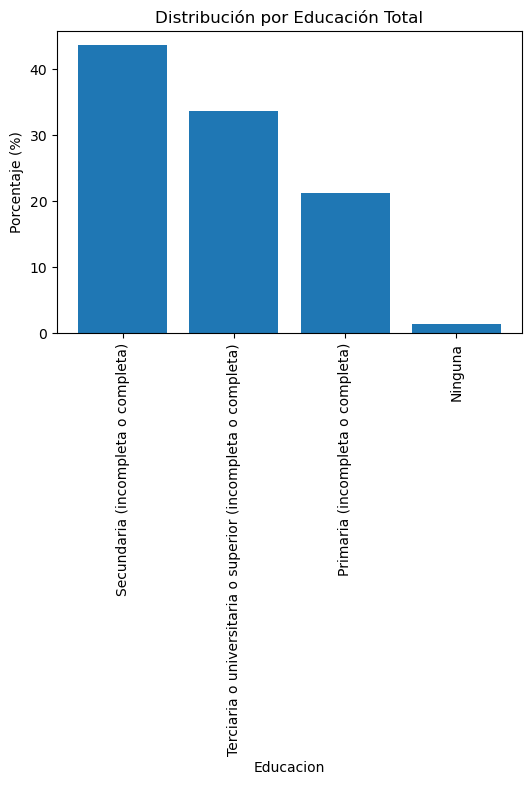

In [37]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop.groupby('edr_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted_total = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted_total.index, users_per_grade_pct_sorted_total.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Educacion")
plt.title('Distribución por Educación Total')
plt.xticks(rotation=90)
plt.show()

In [40]:
from scipy.stats import chi2_contingency

# Datos de ejemplo
submuestra = [1, 2, 3, 2, 1, 1, 4, 3, 2, 3, 1, 4, 4, 4, 3]

# Contar las frecuencias observadas
frecuencias_obs = [submuestra.count(i) for i in range(1, 5)]

# Frecuencias esperadas uniformes (asumiendo igual probabilidad para cada categoría)
frecuencias_esp = [len(submuestra) // 4] * 4

# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)+[0]])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 308.4258906702435
Valor p: 1.4930886468297196e-66


## Ingresos

In [55]:
lpop['q10newt'].isnull().sum()/lpop.shape[0]

0.5669212886084357

In [56]:
lpop_cohere['q10newt'].isnull().sum()/lpop_cohere.shape[0]

1.0

In [41]:
lpop_cohere['q10newt_label'] = lpop_cohere['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\107232878.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['q10newt_label'] = lpop_cohere['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])


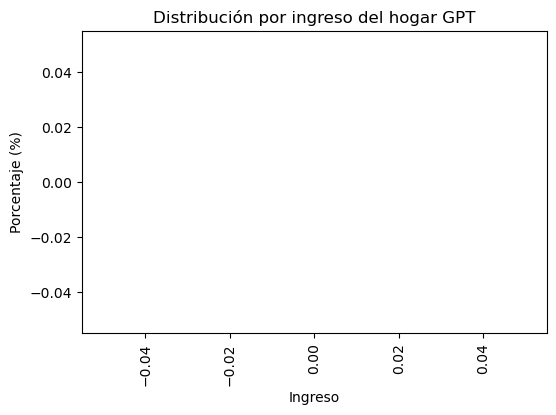

In [42]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop_cohere.groupby('q10newt_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Ingreso")
plt.title('Distribución por ingreso del hogar GPT')
plt.xticks(rotation=90)
plt.show()

In [55]:
users_per_grade_pct_sorted

Series([], Name: wt, dtype: float32)

In [74]:
lpop['q10newt_label'] = lpop['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_4924\3273679197.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['q10newt_label'] = lpop['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])


In [78]:
users_per_grade

Series([], Name: wt, dtype: float32)

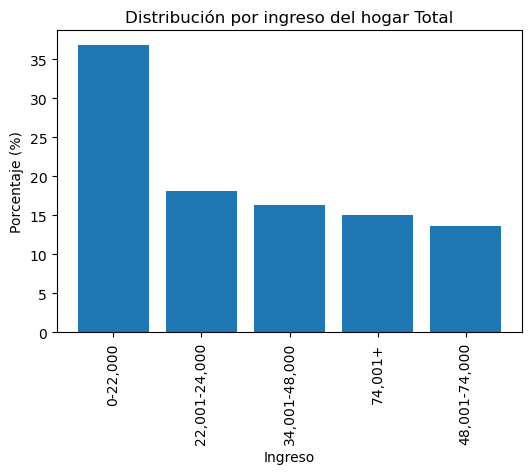

In [76]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('q10newt_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Ingreso")
plt.title('Distribución por ingreso del hogar Total')
plt.xticks(rotation=90)
plt.show()

In [77]:
from scipy.stats import chi2_contingency

# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([ list(users_per_grade_total.values),list(users_per_grade.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

## Conocimiento de política

In [43]:
lpop_cohere['conocim_label'] = lpop_cohere['conocim'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['conocim_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\3410860138.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['conocim_label'] = lpop_cohere['conocim'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['conocim_esp'][x])


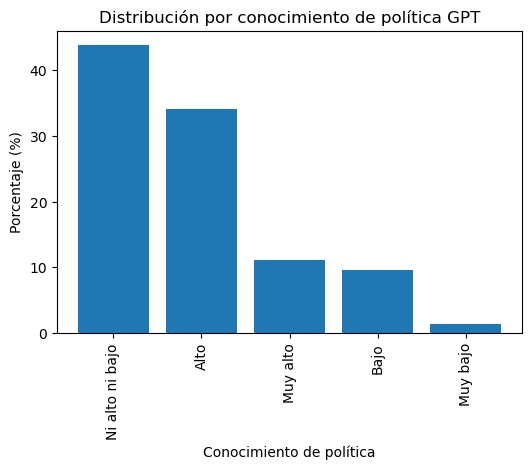

In [44]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop_cohere.groupby('conocim_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Conocimiento de política")
plt.title('Distribución por conocimiento de política GPT')
plt.xticks(rotation=90)
plt.show()

In [45]:
users_per_grade_pct_sorted

conocim_label
Ni alto ni bajo    43.849346
Alto               34.137318
Muy alto           11.119153
Bajo                9.621216
Muy bajo            1.272974
Name: wt, dtype: float32

In [46]:
lpop['conocim_label'] = lpop['conocim'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['conocim_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\3490274094.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['conocim_label'] = lpop['conocim'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['conocim_esp'][x])


In [47]:
users_per_grade_pct_sorted

conocim_label
Ni alto ni bajo    43.849346
Alto               34.137318
Muy alto           11.119153
Bajo                9.621216
Muy bajo            1.272974
Name: wt, dtype: float32

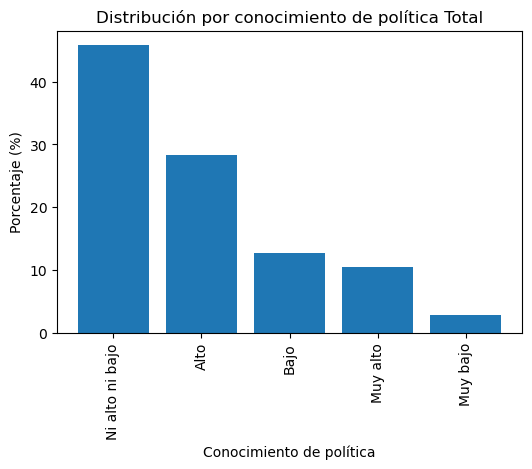

In [48]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('conocim_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Conocimiento de política")
plt.title('Distribución por conocimiento de política Total')
plt.xticks(rotation=90)
plt.show()

In [49]:
from scipy.stats import chi2_contingency

# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([ list(users_per_grade_total.values),list(users_per_grade.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 7.714249095028341
Valor p: 0.10262456585813812


## Etnicidad

In [50]:
lpop_cohere['etid_label'] = lpop_cohere['etid'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['etid_esp'][x])
lpop['etid_label'] = lpop['etid'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['etid_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\2826530488.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop_cohere['etid_label'] = lpop_cohere['etid'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['etid_esp'][x])
C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_7028\2826530488.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['etid_label'] = lpop['etid'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['etid_esp'][x])


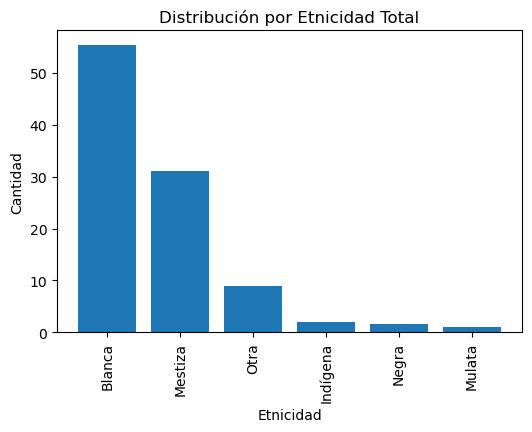

In [51]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('etid_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Etnicidad")
plt.title('Distribución por Etnicidad Total')
plt.xticks(rotation=90)
plt.show()


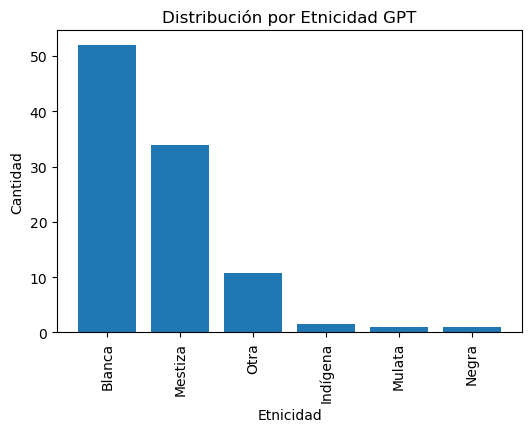

In [52]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_cohere.groupby('etid_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct_gpt = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct_gpt.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Etnicidad")
plt.title('Distribución por Etnicidad GPT')
plt.xticks(rotation=90)
plt.show()


In [53]:
from scipy.stats import chi2_contingency

# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([ list(users_per_grade_total.values),list(users_per_grade_gpt.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 3.0908333140720883
Valor p: 0.6859842868734031


## Diferencias significativas entre quienes opinaron como Cohere y el total

- Edad: Bard es más joven
- Nivel educativo: Bard tiene mayor nivel educativo

## No se diferencian en:

- Etnicidad
- Nivel de ingreso (no pude medirlo)
- politizacion
- 
- Urbanizacion
- Genero

In [97]:
lpop = lpop.sort_values(by='bard_distance_norm', ascending=True)

# 2. Calcular el número de filas que representa el 10%
num_rows_10_percent = int(len(lpop) * 0.1)

# 3. Seleccionar las primeras filas correspondientes al 10%
lpop_cohere = lpop[(lpop['bard_num_preg']>5)].head(num_rows_10_percent)

In [98]:
expanded_df = lpop_cohere.loc[np.repeat(lpop_cohere.index.values, lpop_cohere['wt']*100)]

# Resetear los índices
expanded_df = expanded_df.reset_index(drop=True)

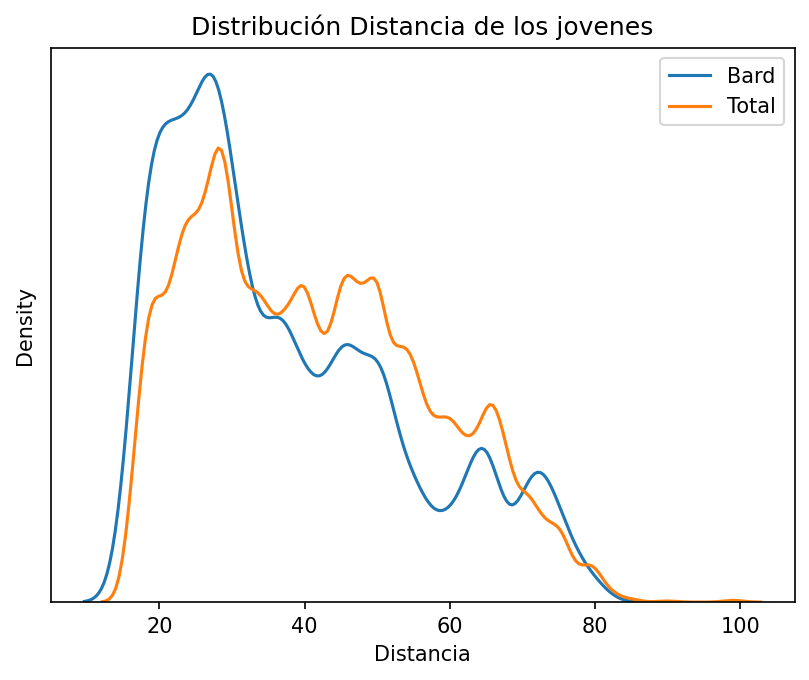

In [76]:

plt.figure(dpi=150)
edad_bard = np.repeat(lpop_cohere['q2'], lpop_cohere['wt']*100) 
edad_total = np.repeat(lpop['q2'], lpop['wt']*100) 
sns.kdeplot(
   edad_bard, label="Bard"
)
sns.kdeplot(
   edad_total, label="Total"
)
plt.title("Distribución Distancia de los jovenes")
plt.xlabel("Edad")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.show()

In [91]:
edad_bard.median()

33.0

In [92]:
edad_total.median()

40.0

In [90]:
from scipy.stats import ttest_ind

# Realizar la prueba 
estadistico, p_valor = ttest_ind(list(edad_bard.values), list(edad_total.values))

print("Estadístico de prueba t:", estadistico)
print("Valor p:", p_valor)

Estadístico de prueba t: -37.87208204628485
Valor p: 0.0


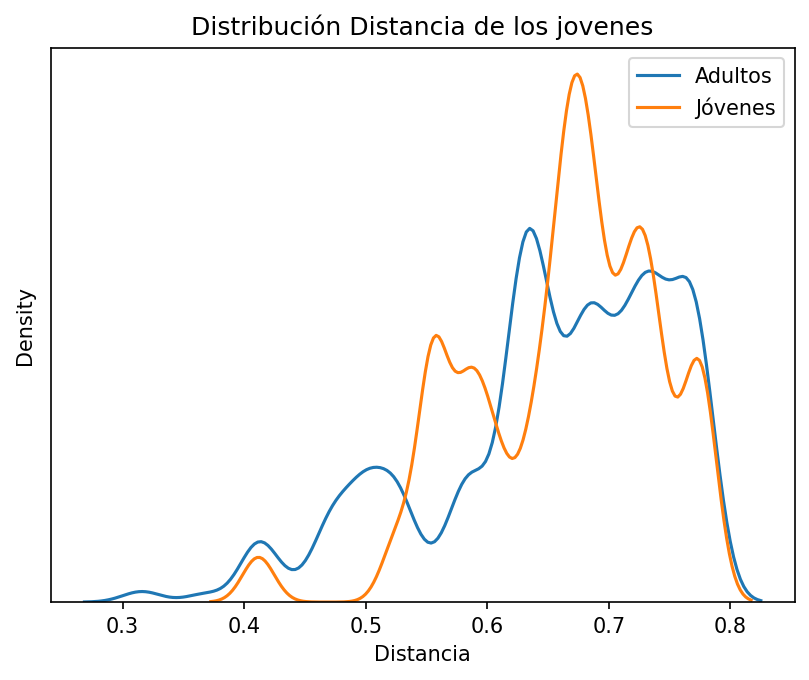

In [99]:

lpop_adulto = expanded_df[expanded_df['q2']>40]
lpop_joven = expanded_df[expanded_df['q2']<25]
plt.figure(dpi=150)
new_data = np.repeat(df['Edad'], df['Ponderador']*100) 
sns.kdeplot(
   lpop_adulto['bard_distance_norm'], label="Adultos"
)
sns.kdeplot(
   lpop_joven['bard_distance_norm'], label="Jóvenes"
)
plt.title("Distribución Distancia de los jovenes")
plt.xlabel("Distancia")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.show()

In [58]:
lpop_adulto['bard_distance_norm'].median()

0.6842105263157895

In [59]:
lpop_joven['bard_distance_norm'].median()

0.6842105263157895

In [74]:
len(new_data)

100

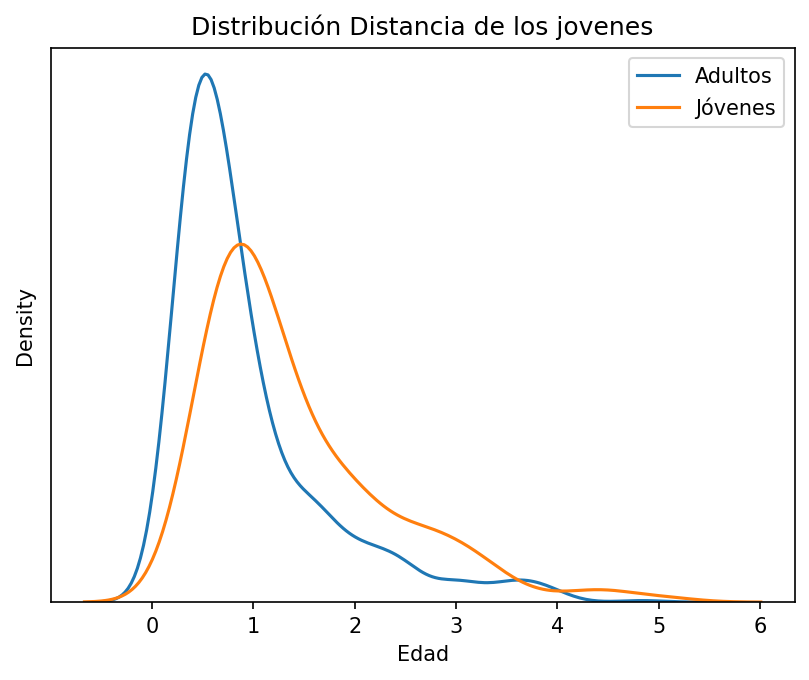

In [44]:
plt.figure(dpi=150)
lpop_cohere_dist = lpop[(lpop['bard_num_preg']>5)]
lpop_adulto = lpop_cohere_dist[lpop_cohere_dist['q2']>40]
lpop_joven = lpop_cohere_dist[lpop_cohere_dist['q2']<25]
sns.kdeplot(
   lpop_adulto[lpop_adulto['bard_num_preg']>8]['bard_distance_norm_wt'], label="Adultos"
)
sns.kdeplot(
   lpop_joven[lpop_joven['bard_num_preg']>8]['bard_distance_norm_wt'], label="Jóvenes"
)
plt.title("Distribución Distancia de los jovenes")
plt.xlabel("Edad")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.show()

In [47]:
from scipy.stats import ttest_ind

# Realizar la prueba 
estadistico, p_valor = ttest_ind((lpop_cohere['q2'].values), (lpop_cohere_5p['q2'].values))

print("Estadístico de prueba t:", estadistico)
print("Valor p:", p_valor)

Estadístico de prueba t: -3.0408584903550437
Valor p: 0.00239366357202245


In [48]:
lpop_cohere['q2'].median()

37.0

In [50]:
lpop_cohere['q2'].std()

15.48305829384736

In [51]:
lpop['q2'].median()

41.0

In [52]:
lpop['q2'].std()

15.064155955151723

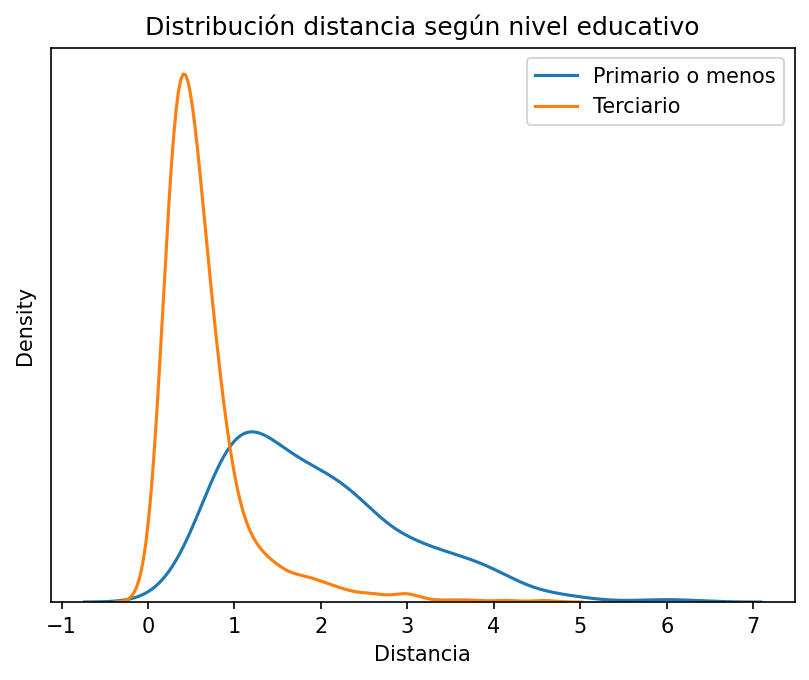

In [22]:
lpop_adulto = lpop[lpop['edr']<=1]
lpop_joven = lpop[lpop['edr']==3]
plt.figure(dpi=150)

sns.kdeplot(
   lpop_adulto[lpop_adulto['bard_num_preg']>8]['bard_distance_norm_wt'], label="Primario o menos"
)
sns.kdeplot(
   lpop_joven[lpop_joven['bard_num_preg']>8]['bard_distance_norm_wt'], label="Terciario"
)
plt.title("Distribución distancia según nivel educativo")
plt.xlabel("Distancia")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.show()

In [23]:
reader.value_labels()['conocim_esp']

{1: 'Muy alto', 2: 'Alto', 3: 'Ni alto ni bajo', 4: 'Bajo', 5: 'Muy bajo'}

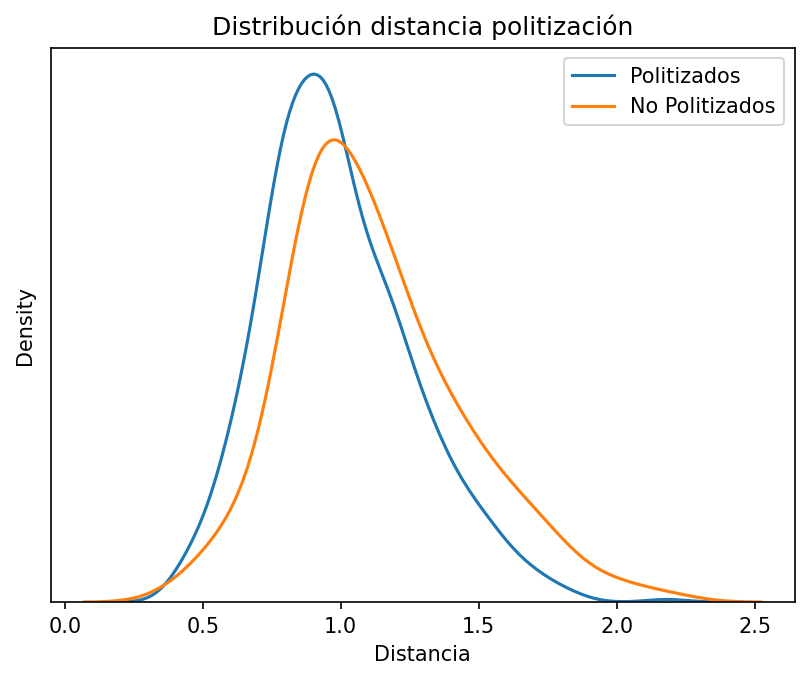

In [23]:
lpop_adulto = lpop[lpop['conocim']<=2]
lpop_joven = lpop[lpop['conocim']>=4]
plt.figure(dpi=150)

sns.kdeplot(
   lpop_adulto[lpop_adulto['bard_num_preg']>8]['bard_distance_norm'], label="Politizados"
)
sns.kdeplot(
   lpop_joven[lpop_joven['bard_num_preg']>8]['bard_distance_norm'], label="No Politizados"
)
plt.title("Distribución distancia politización")
plt.xlabel("Distancia")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.show()